In [ ]:
# Connect to Google drive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 18.9 MB/s eta 0:00:00


In [ ]:
# Import libraries
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr
import seaborn as sns
from pathlib import Path
import numpy as np
import matplotlib

In [ ]:
#import dataset
fatigue_df = pd.read_csv('../Data/Titanium_Alloy_UC.csv', encoding='latin1')
fatigue_df

,SL. Number,Number of Cycles,Stress (MPa),Solution Temperature (°C),Solution Time (hrs),Temperature Measurement (°C),Ann/Age. temp (cel),Ann/age time (hrs),Total Strain (%),R,...,C,N,O,H,Fe,Si,Sn,Nb,Mo,Zr
0,123,100000,860.00,932,0.0,25,704,2.0,0.0,0.5,...,0.00,0.0120,0.18,0.0000,0.20,0.00,0.0,0.0,0.0,0.0
1,126,100000,850.00,925,1.0,25,700,2.0,0.0,0.5,...,0.00,0.0120,0.18,0.0041,0.20,0.00,0.0,0.0,0.0,0.0
2,158,1000000,800.00,932,0.0,25,704,2.0,0.0,0.5,...,0.00,0.0120,0.18,0.0000,0.20,0.00,0.0,0.0,0.0,0.0
3,161,1000000,780.00,925,1.0,25,700,2.0,0.0,0.5,...,0.00,0.0120,0.18,0.0041,0.20,0.00,0.0,0.0,0.0,0.0
4,164,1000000,699.00,0,0.0,25,700,2.0,0.0,0.5,...,0.00,0.0130,0.19,0.0041,0.19,0.00,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215,18,249,915.24,1020,1.0,25,0,0.0,0.8,-1.0,...,0.05,0.0025,0.00,0.0040,0.00,0.34,4.0,0.7,0.5,3.7
216,27,325,910.82,1020,1.0,25,0,0.0,0.8,-1.0,...,0.05,0.0025,0.00,0.0040,0.00,0.34,4.0,0.7,0.5,3.7
217,31,370,907.55,1020,1.0,25,0,0.0,0.8,-1.0,...,0.05,0.0025,0.00,0.0040,0.00,0.34,4.0,0.7,0.5,3.7
218,41,444,900.00,1020,1.0,25,0,0.0,0.8,-1.0,...,0.05,0.0025,0.00,0.0040,0.00,0.34,4.0,0.7,0.5,3.7


In [ ]:
fatigue_df.info()

# Sort the data by ascending order of number of cycles
fatigue_df.sort_values(by=['Number of Cycles'], ascending=True, ignore_index=True, inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220 entries, 0 to 219
Data columns (total 24 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   SL. Number                    220 non-null    int64  
 1   Number of Cycles              220 non-null    int64  
 2   Stress (MPa)                  220 non-null    float64
 3   Solution Temperature (°C)     220 non-null    int64  
 4   Solution Time (hrs)           220 non-null    float64
 5   Temperature Measurement (°C)  220 non-null    int64  
 6   Ann/Age. temp (cel)           220 non-null    int64  
 7   Ann/age time (hrs)            220 non-null    float64
 8   Total Strain (%)              220 non-null    float64
 9   R                             220 non-null    float64
 10  Frequency (Hz)                220 non-null    float64
 11  Ti                            220 non-null    float64
 12  Al                            220 non-null    float64
 13  V    

In [ ]:
# Remove columns that are not needed
drop_cols = ['Number of Cycles','SL. Number'] # list the columns to drop along with target for independent feautures

# Use all remaining columns as features
features = fatigue_df.drop(drop_cols, axis=1)

# Use log transform of the number of cycles as targets
targets = np.log10(fatigue_df['Number of Cycles'])

# Display the features
features

,Stress (MPa),Solution Temperature (°C),Solution Time (hrs),Temperature Measurement (°C),Ann/Age. temp (cel),Ann/age time (hrs),Total Strain (%),R,Frequency (Hz),Ti,...,C,N,O,H,Fe,Si,Sn,Nb,Mo,Zr
0,1067.63,1020,1.0,25,700,2.0,1.25,-1.0,0.2,84.90,...,0.050,0.0025,0.000,0.004,0.000,0.340,4.00,0.70,0.500,3.70
1,685.38,1025,2.0,450,1025,2.0,1.00,0.0,0.0,85.01,...,0.065,0.0020,0.090,0.000,0.000,0.305,4.02,0.71,0.505,3.54
2,649.41,1025,2.0,500,1025,2.0,1.00,0.0,0.0,85.01,...,0.065,0.0020,0.090,0.000,0.000,0.305,4.02,0.71,0.505,3.54
3,725.00,1025,2.0,375,1025,2.0,1.00,0.0,0.0,85.01,...,0.065,0.0020,0.090,0.000,0.000,0.305,4.02,0.71,0.505,3.54
4,711.56,1025,2.0,425,1025,2.0,1.00,0.0,0.0,85.01,...,0.065,0.0020,0.090,0.000,0.000,0.305,4.02,0.71,0.505,3.54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215,253.59,0,0.0,25,1300,4.0,0.00,0.0,20.0,52.39,...,0.016,0.5300,0.002,0.023,0.000,0.000,0.00,18.70,0.000,0.00
216,400.00,0,0.0,600,0,0.0,0.00,0.1,30.0,84.69,...,0.050,0.0025,0.105,0.004,0.009,0.340,4.00,0.69,0.540,3.72
217,282.17,0,0.0,600,1300,4.0,0.00,0.0,20.0,52.39,...,0.016,0.5300,0.002,0.023,0.000,0.000,0.00,18.70,0.000,0.00
218,500.00,0,0.0,25,0,0.0,0.00,-1.0,30.0,84.69,...,0.050,0.0025,0.105,0.004,0.009,0.340,4.00,0.69,0.540,3.72


In [ ]:
 # Calculate the coverage percentage of values within a specified range
 def coverage(y, yL, yH):
        return np.sum(100 / y.shape[0] * ((y>yL)&(y<yH)))

q: 0.025 | pearsonr: 0.9121197150162377
q: 0.5 | pearsonr: 0.9456540072355467
q: 0.975 | pearsonr: 0.9255843045605214
Pearson CC: 0.9456540072355467
R2 score: 0.8813096436611199
RMSE: 0.6829390128124893
MAE: 0.5154044927098668
Coverage: 81.81818181818183
Interval Width: 2.0378322998498324
Composite Metric: 0.7363157421202667


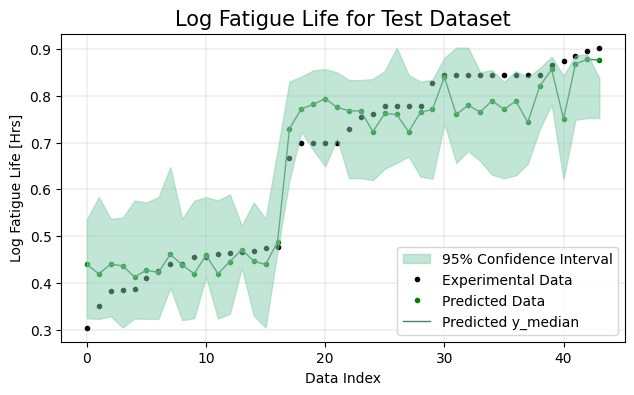

****************************************
q: 0.025 | pearsonr: 0.93347771227433
q: 0.5 | pearsonr: 0.9487007017585048
q: 0.975 | pearsonr: 0.91931263078178
Pearson CC: 0.9487007017585048
R2 score: 0.8985590611497388
RMSE: 0.5820103254759926
MAE: 0.41046801345727135
Coverage: 95.45454545454544
Interval Width: 2.8981897463934736
Composite Metric: 0.8021698336058386


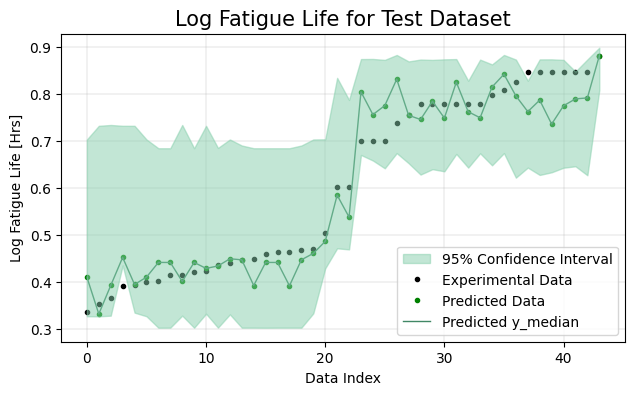

****************************************
q: 0.025 | pearsonr: 0.8589952533001791
q: 0.5 | pearsonr: 0.8996627321577744
q: 0.975 | pearsonr: 0.9220365921625945
Pearson CC: 0.8996627321577744
R2 score: 0.8074712152298592
RMSE: 0.8059863741842003
MAE: 0.5128650130894605
Coverage: 81.81818181818183
Interval Width: 1.7226645165604633
Composite Metric: 0.758760383778811


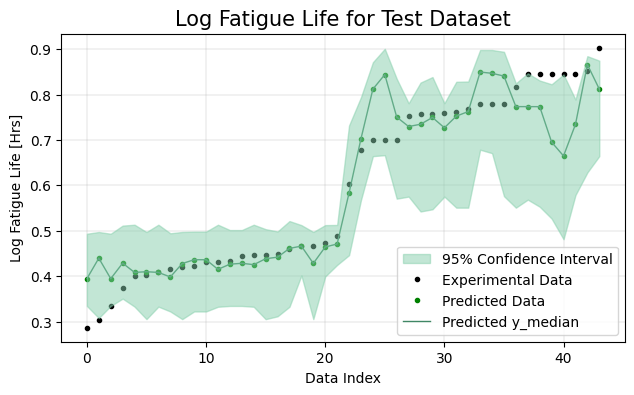

****************************************
q: 0.025 | pearsonr: 0.9517607287181883
q: 0.5 | pearsonr: 0.9489366472888895
q: 0.975 | pearsonr: 0.9231125475149656
Pearson CC: 0.9489366472888895
R2 score: 0.8945404890837225
RMSE: 0.6163800906762243
MAE: 0.4043016934732753
Coverage: 72.72727272727273
Interval Width: 1.7717631301027912
Composite Metric: 0.6865569285848998


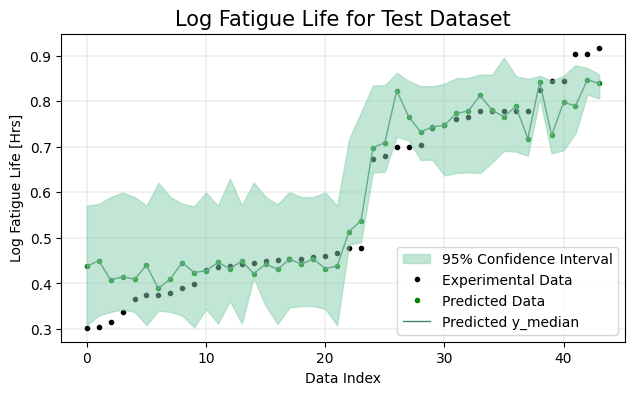

****************************************
q: 0.025 | pearsonr: 0.9008747359110011
q: 0.5 | pearsonr: 0.9066293315277412
q: 0.975 | pearsonr: 0.9166512642015766
Pearson CC: 0.9066293315277412
R2 score: 0.8196424228704111
RMSE: 0.7900145938609052
MAE: 0.5572560511431596
Coverage: 54.54545454545455
Interval Width: 0.9455875136493634
Composite Metric: 0.6734768029307714


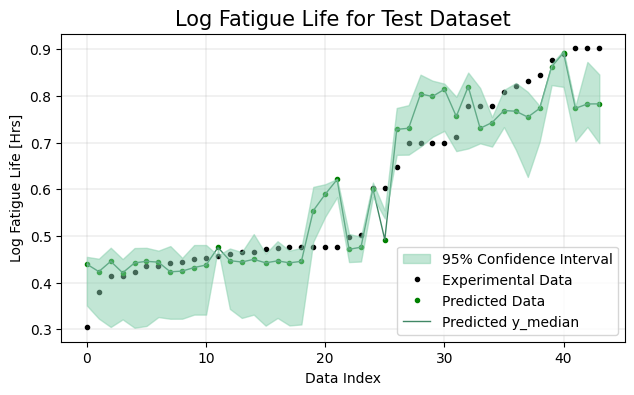

****************************************


In [ ]:
# Evaluate multiple runs of the model
nruns = 1
nfolds = 5

# Metrics for performance evaluation
PearsonCC = np.zeros((nruns, nfolds))
R2_score = np.zeros_like(PearsonCC)
RMSE = np.zeros_like(PearsonCC)
MAE = np.zeros_like(PearsonCC)

test_coverage = np.zeros_like(PearsonCC)
median_interval_width = np.zeros_like(PearsonCC)
composite_metric = np.zeros_like(PearsonCC)

quantiles = [0.025, 0.5, 0.975]

for j in range(nruns):

        kf = KFold(n_splits=nfolds, shuffle=True, random_state=123+j)

        for i, (tr, ts) in enumerate(kf.split(targets)):
                X_train, X_test = features.iloc[tr], features.iloc[ts]
                scale = StandardScaler()
                X_train = scale.fit_transform(X_train)
                X_test = scale.transform(X_test)
                y_train, y_test = targets.iloc[tr], targets.iloc[ts]
                X_train, X_val, y_train, y_val = train_test_split(
                        X_train, y_train, test_size=0.1)

                for q in quantiles:
                        parameters = {'loss_function': 'Quantile:alpha={:0.2f}'.format(q),
                                'num_boost_round': 5000}
                        model = CatBoostRegressor(**parameters)
                        model.fit(X_train, np.log(y_train),
                                eval_set=[(X_val, np.log(y_val))],
                                early_stopping_rounds=20,
                                verbose=False)
                        y_pred = np.exp(model.predict(X_test))
                        print(f'q: {q} | pearsonr: {pearsonr(y_test, y_pred)[0]}')
                        if q==0.025:
                           y_low = y_pred
                        elif q==0.5:
                                y_median = y_pred
                        elif q==0.975:
                               y_high = y_pred

                PearsonCC[j, i] = pearsonr(np.squeeze(y_test), np.squeeze(y_median))[0]
                R2_score[j, i] = r2_score(y_test, y_median)
                RMSE[j, i] = np.sqrt(mean_squared_error(y_test, y_median))
                MAE[j, i] = np.mean(abs(y_median-np.array(y_test)))

                print(f'Pearson CC: {PearsonCC[j, i]}')
                print(f'R2 score: {R2_score[j, i]}')
                print(f'RMSE: {RMSE[j, i]}')
                print(f'MAE: {MAE[j, i]}')

                test_coverage[j, i] = coverage(y_test, y_low, y_high)
                print(f'Coverage: {test_coverage[j, i]}')

                # Prediction interval width
                median_interval_width[j, i] = np.median(y_high - y_low)
                print(f'Interval Width: {median_interval_width[j, i]}')

                # Composite metric that combines the coverage and the invers of interval width
                composite_metric[j, i] = 0.75*test_coverage[j, i]/100 + 0.25*(1/median_interval_width[j, i])
                print(f'Composite Metric: {composite_metric[j, i]}')

                # Plot the predictions
                fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))

                iteration_list = [i for i in range(len(y_test))]
                ## Uncertainty quantification plot
                ax[0].fill_between(iteration_list, np.log10(y_low), np.log10(y_high), alpha=0.5, color='#86cfac', zorder=5, label='95% Confidence Interval')
                ax[0].plot(iteration_list, np.log10(y_test), 'ko', markersize=3, label="Experimental Data")
                ax[0].plot(iteration_list, np.log10(y_median), 'go', markersize=3, label="Predicted Data")
                ax[0].plot(iteration_list, np.log10(y_median), '-', linewidth=1, color="#408765", label="Predicted y_median")
                ax[0].legend(loc=4, fontsize=10, frameon=True)
                ax[0].set_xlabel("Data Index", fontsize=10)
                ax[0].set_ylabel("Log Fatigue Life [Hrs]", fontsize=10)
                ax[0].set_title("Log Fatigue Life for Test Dataset", fontsize=15)
                ax[0].grid(True, which='major', linestyle='-', linewidth='0.25')
                fig.delaxes(ax[1])

                plt.show()
                print(40*'*')

In [ ]:
# Data frame
df1 = pd.DataFrame({'Pearson CC': PearsonCC.flatten(), 'R2 Score': R2_score.flatten(), 'RMSE': RMSE.flatten(),
                    'MAE': MAE.flatten()},index=None)
df1

,Pearson CC,R2 Score,RMSE,MAE
0,0.945654,0.881310,0.682939,0.515404
1,0.948701,0.898559,0.582010,0.410468
2,0.899663,0.807471,0.805986,0.512865
3,0.948937,0.894540,0.616380,0.404302
4,0.906629,0.819642,0.790015,0.557256


In [ ]:
# Calculate mean values and standard deviations of the scores
PearsonCC_mean = np.mean(PearsonCC)
R2_score_mean = np.mean(R2_score)
RMSE_mean = np.mean(RMSE)
MAE_mean = np.mean(MAE)

PearsonCC_std = np.std(PearsonCC)
R2_score_std = np.std(R2_score)
RMSE_std = np.std(RMSE)
MAE_std = np.std(MAE)

# Data frame
df2 = pd.DataFrame({'Pearson CC Mean': PearsonCC_mean, 'Pearson CC Std': PearsonCC_std, 'R2 Score Mean': R2_score_mean, 'R2 Score Std': R2_score_std,
                  'RMSE Mean': RMSE_mean, 'RMSE Std': RMSE_std, 'MAE Mean': MAE_mean, 'MAE Std':MAE_std,
                   },index=[0])
df2

,Pearson CC Mean,Pearson CC Std,R2 Score Mean,R2 Score Std,RMSE Mean,RMSE Std,MAE Mean,MAE Std
0,0.929917,0.021999,0.860305,0.038785,0.695466,0.089931,0.480059,0.061428


In [ ]:
# Data frame
df3 = pd.DataFrame({'Coverage': test_coverage.flatten(), 'Interval Width': median_interval_width.flatten(), 'Composite Metric': composite_metric.flatten()},index=None)
df3

,Coverage,Interval Width,Composite Metric
0,81.818182,2.037832,0.736316
1,95.454545,2.898190,0.802170
2,81.818182,1.722665,0.758760
3,72.727273,1.771763,0.686557
4,54.545455,0.945588,0.673477


In [ ]:
# Calculate mean values and standard deviations of the scores
test_coverage_mean = np.mean(test_coverage)
median_interval_width_mean = np.mean(median_interval_width)
composite_metric_mean = np.mean(composite_metric)

test_coverage_std = np.std(test_coverage)
median_interval_width_std = np.std(median_interval_width)
composite_metric_std = np.std(composite_metric)

# Data frame
df4 = pd.DataFrame({'Coverage Mean': test_coverage_mean, 'Coverage Std': test_coverage_std,
                    'Interval Width Mean': median_interval_width_mean, 'Interval Width Std':median_interval_width_std,
                   'Composite Metric Mean': composite_metric_mean, 'Composite Metric Std': composite_metric_std,},index=[0])
df4

,Coverage Mean,Coverage Std,Interval Width Mean,Interval Width Std,Composite Metric Mean,Composite Metric Std
0,77.272727,13.483997,1.875207,0.62787,0.731456,0.047217
